In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# MultiIndex
# df = pd.read_excel('./给林师兄/part1.xlsx',sheet_name=0,index_col =[0,1])
#pivot
# unstack
#去掉QC样本
df = pd.read_excel('./给林师兄/part1.xlsx',sheet_name=0)
mask = df.loc[:,'Sample Name'].isin(['QC'])
df1 = df.loc[~mask]
dfQC = df.loc[mask]
sample_name = df.loc[:,'Sample Name']
Component_name = df.loc[:,'Component Name']
QCgrp = ((sample_name =='QC')& (Component_name==1)).cumsum()
#bug 如果没有component 1
df.loc[:,'QCgrp'] = QCgrp

In [3]:
df.head()

,Sample Name,Component Name,Area,QCgrp
0,QC,1,2468.0,1
1,QC,2,131000.0,1
2,QC,3,5057.0,1
3,QC,4,6648.0,1
4,QC,5,3875000.0,1


In [4]:
a = df.set_index(['Sample Name','QCgrp','Component Name']).dropna().unstack('Component Name')
a.columns = a.columns.droplevel(0)
a.index = a.index.droplevel(1).map(str)
a.sort_index(ascending=False).head()

Component Name,1,2,3,4,5,6,7,8,9,10,...,230,56?,IS-1,IS-2,IS-3,IS-4,IS-5,IS-6,IS-7,IS-8
Sample Name,,,,,,,,,,,,,,,,,,,,,
ST-P,535.5,83640.0,4603.0,5672.0,2731000.0,11800000.0,14030000.0,3116000.0,22300.0,288800.0,...,217.0,5173.0,2503000.0,914800.0,2312.0,6563.0,2163000.0,173800.0,3323000.0,691300.0
QC,1582.0,63760.0,2620.0,2948.0,2109000.0,8589000.0,10480000.0,2576000.0,13100.0,203500.0,...,731.8,2023.0,2046000.0,678900.0,8252.0,13520.0,1568000.0,144000.0,1092000.0,409500.0
QC,2468.0,131000.0,5057.0,6648.0,3875000.0,14550000.0,17930000.0,4608000.0,30710.0,389700.0,...,5342.0,NaN,3864000.0,1001000.0,13280.0,19100.0,2945000.0,296900.0,4557000.0,644100.0
QC,2698.0,184600.0,5780.0,5345.0,3591000.0,13470000.0,16530000.0,4548000.0,35430.0,351200.0,...,6340.0,2728.0,3550000.0,955800.0,12580.0,20390.0,2614000.0,214300.0,4283000.0,678000.0
QC,3272.0,186900.0,6138.0,5345.0,3649000.0,14470000.0,17590000.0,4420000.0,35290.0,371500.0,...,3775.0,4955.0,3402000.0,938500.0,12640.0,17170.0,2822000.0,224800.0,4755000.0,665500.0


In [44]:
from Chemometrics.import_common import *

In [46]:
psave(df,'QC_sample.p')

- QC没有编号的区分  
    容易bug

# 数据校正

In [6]:
#校正峰面积
#QC 校正
# 自变量x 是时间还是进样编号?

In [26]:
a = df[df['Component Name']==1].reset_index(drop=True)

In [36]:
a = df[df['Component Name']==1].reset_index(drop=True)
qc = a[a['Sample Name']=='QC']
sample = a[a['Sample Name']!='QC']

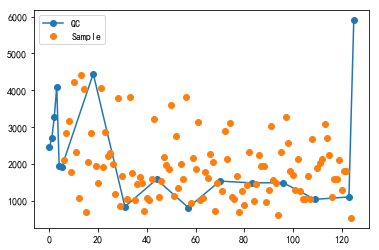

In [42]:
plt.plot(qc.index,qc.Area,'o-',label='QC')
plt.plot(sample.index,sample.Area,'o',label='Sample')
plt.legend()

 ### Loess分段拟合

# 拟合

In [46]:
a = pd.read_excel('./给林师兄/part2.xlsx',sheet_name=1)
# Area Ratio
dfna = a.loc[a.Used].sort_values('Sample Name').dropna()
dfna.head()

,Sample Name,Used,Component Name,Actual Concentration,Area Ratio
4,0.5P,True,1,0.25,0.000
1963,0.5P,True,103,0.25,0.078
1962,0.5P,True,103,0.25,0.080
1941,0.5P,True,102,0.25,0.023
1984,0.5P,True,105,0.25,0.012


##  Area Ratio 
缺失值

In [49]:
def olsfit(dfi):
    #OLS拟合
    # regression Area Ratio on Actual Concentration
    # 用浓度对峰面积回归
    x = dfi.loc[:,'Actual Concentration']
    x = sm.add_constant(x)
    y = dfi.loc[:,'Area Ratio']
    results = sm.OLS(y,x).fit()# w = X'*y/(X'*X)
    a = results.params
    a.loc['rsquared'] = results.rsquared
    a.loc['线性方程'] = 'y = {1}x+{0}'.format(*results.params.round(4))
    a.loc['model'] = results
    return a

# x y 反了？

In [48]:
res = dfna.drop(['Sample Name','Used'],axis=1).groupby('Component Name').apply(olsfit)
res.head()

,const,Actual Concentration,rsquared,线性方程,model
Component Name,,,,,
1,0.000108,0.001059,0.840830,y = 0.0011x+0.0001,<statsmodels.regression.linear_model.Regressio...
2,0.007605,0.046809,0.977913,y = 0.0468x+0.0076,<statsmodels.regression.linear_model.Regressio...
3,0.000489,0.001709,0.919868,y = 0.0017x+0.0005,<statsmodels.regression.linear_model.Regressio...
4,0.001429,0.000847,0.912026,y = 0.0008x+0.0014,<statsmodels.regression.linear_model.Regressio...
5,0.089932,1.248525,0.899965,y = 1.2485x+0.0899,<statsmodels.regression.linear_model.Regressio...


#画图
~~~
mask = dfna.loc[:,'Component Name'] ==1
dfi = dfna.loc[mask]
from statsmodels.sandbox.regression.predstd import wls_prediction_std
x = dfi.loc[:,'Actual Concentration']
x = sm.add_constant(x)
y = dfi.loc[:,'Area Ratio']
results = sm.OLS(y,x).fit()
prstd, iv_l, iv_u = wls_prediction_std(results)
res = results
fig, ax = plt.subplots(figsize=(8,6))
x = dfi.loc[:,'Actual Concentration']
y = results.predict()
y_true = dfi.loc[:,'Area Ratio']
ax.plot(x, y, 'o', label="data")
ax.plot(x, y_true, 'bo', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');
~~~

 predict

In [3]:
A = pd.read_excel('./给林师兄/part2.xlsx',sheet_name=1)

# grouping

GroupBy  
    keys

# keys
    1. python function apply to axis
    2. list or numpy array, the length as the selected axis
    3. a dict or series mapping of {label:group name}
    4. a dataframe objects. df.groupby(df['A']) --> df.groupby('A')
    5. a list of any of the above things

group keys is sorted. within group origin order is preserved 
speedup  
pd.Grouper  
groups. a dict{keys:index}  
get_group  

In [25]:
A.head()

,Sample Name,Used,Component Name,Actual Concentration,Area Ratio
0,0.1P,False,1,0.05,0.0
1,0.1P,False,1,0.05,0.0
2,0.25P,False,1,0.10,0.0
3,0.25P,False,1,0.10,0.0
4,0.5P,True,1,0.25,0.0


In [24]:
grp = A.groupby('Sample Name',sort=False)

# Aggregation
- window
- resample

In [38]:
grp.agg([sum,np.mean]).head(1)

Used           Actual Concentration          Area Ratio          
              sum      mean                  sum     mean        sum      mean
Sample Name                                                                   
0.1P         16.0  0.038095                 36.2  0.08619     39.873  0.106045

In [42]:
#apply different functions to different columns
grp.aggregate({'Used':sum,'Actual Concentration':[np.mean,sum]}).head(1)

Used Actual Concentration      
              sum                 mean   sum
Sample Name                                 
0.1P         16.0              0.08619  36.2

cython优化:sum,mean,std,sem

# Transformation

same size  
- broadcastable  
group chunk  
zscore

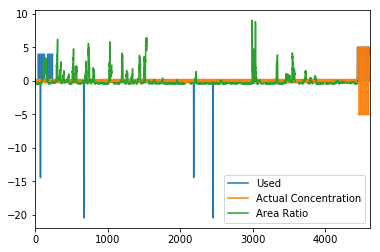

In [49]:
zscore = lambda x:(x-x.mean())/x.std()
grp.transform(zscore).plot()

- rolling, expanding, resample

- resample

# Filtration 

dropna = False  
groupby dispacth method

# Dispatching to instance methods

# Apply  
flexible

- nuisance
- ordered factors
- grouper function

- Plotting

- piping function calls
- unstack
- stack